 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 7. Neural Network Improvements**
# Section 2. Weight Initialization

### _Objective_
1. 심층신경망이 깊어짐에 따라 발생하는 Gradient Vanishing과 Gradient Exploding에 대해 배워보도록 하겠습니다. <br>
2. 가중치를 왜 랜덤으로 초기화해야 하는지에 대해 배워보도록 하겠습니다. <br>
3. 가중치를 초기화하는 대표적인 방법인 Xavier와 He init에 대해 배워보도록 하겠습니다.
  
╚═════════════════════════════════════════╝

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

<br><br>

# \[ 1. Gradient Vanishing과 Gradient Exploding \]

----

----

> *신경망은 깊어질수록, 신경망을 학습시키기가 어려워집니다. 깊어질수록 Gradient가 사라지는 Vanishing 문제 혹은 Gradient가 지나치게 커지는 Exploding 문제가 발생하기 때문입니다.*<br>

## 1. 순전파 과정 수식 일반화하기
![Imgur](https://i.imgur.com/ZHZHpAy.png)


* 위의 모델을 수식으로 풀면 아래와 같습니다.<br>
$
a^{0} = X\\
Z^1 = a^{0}\cdot W^{[1]} + b^{[1]}\\
a^1 = \sigma(Z^1)\\
Z^2 = a^{0}\cdot W^{[2]} + b^{[2]}\\
a^2 = \sigma{Z^2}
$
<br>
* 위의 반복적인 과정을 일반화해서 나타내면, 아래의 관계가 나타납니다.<br>
$
Z^{i+1} = a^{i}\cdot W^{[i+1]} + b^{[i+1]}\\
a^{i+1} = \sigma(z^{i+1})
$

## 2. 순전파 과정에서의 Vanishing과 Exploding
---

* 활성화 함수($\sigma$)와 Bias($b$) 없다고 가정해보겠습니다.<br>
* 그렇다면, 각층의 로짓값($Z$)는 아래의 관계를 가지고 있습니다.<br>
$
Z^{i+1} = X\cdot W^{[1]}\cdot W^{[2]}... \cdot W^{[i+1]}
$

* X의 값이 아래와 같을 때, W의 값에 따라 어떻게 변화하는지 살펴보겠습니다.<br>
$
X = \begin{bmatrix}
0.8 \\
0.2 \\
\end{bmatrix}
$

### (1) Weight의 원소 값이 1보다 클때
$
W = \begin{bmatrix}
1.2 & 0 \\
0 & 1.2 \\
\end{bmatrix}
$

In [2]:
X = np.array([[0.8,0.2]])
W = np.array([[1.2,0.],[0.,1.2]])

Z = X
for i in range(50):
    Z = np.dot(Z,W)
    if i % 10 == 0:
        print("{}th value : {}".format(i,Z))

0th value : [[0.96 0.24]]
10th value : [[5.94406697 1.48601674]]
20th value : [[36.80409593  9.20102398]]
30th value : [[227.88126125  56.97031531]]
40th value : [[1410.98070525  352.74517631]]


초기 값은 모두 0과 1 사이에 위치하였는데, 계산을 반복할수록 그 값이 기하급수적으로 증가합니다.

### (2) Weight의 원소 값이 1보다 작을 때
$
W = \begin{bmatrix}
0.8 & 0 \\
0 & 0.8 \\
\end{bmatrix}
$

In [3]:
X = np.array([[0.8,0.2]])
W = np.array([[0.8,0.],[0.,0.8]])

Z = X
for i in range(50):
    Z = np.dot(Z,W)
    if i % 10 == 0:
        print("{}th value : {}".format(i,Z))

0th value : [[0.64 0.16]]
10th value : [[0.06871948 0.01717987]]
20th value : [[0.0073787  0.00184467]]
30th value : [[0.00079228 0.00019807]]
40th value : [[8.50705917e-05 2.12676479e-05]]


초기 값은 모두 0과 1 사이에 위치하였는데, 계산을 반복할수록 로짓값은 0에 수렴합니다.<br>
이러한 현상은 역전파 과정에서도 동일하게 발생합니다.<br>
초기 Weight에 따라, Gradient가 Vanishing할지, Exploding할지<br>
결정됩니다.

<br>
## 3. 역전파 과정에서의 Vanishing과 Exploding
---

* 그렇다면, 각층의 로짓값($Z^{[i+1]}$)는 계산그래프로 표현한다면 아래의 관계를 가집니다. <br>

![Imgur](https://i.imgur.com/iQvVNOn.png)

위의 수식에서도 전파되는 error값에는 Weight가 반복적으로 곱해지게 됩니다.<br>
이에 따라 Backpropagation을 하는 과정중에서 Gradient는 Vanishing 혹은 Exploding 하게 됩니다.<br>

이는 초기 인공 신경망의 핵심 난제 중 하나였습니다. <br>
이를 해결하기 위해, <br>
1. Weight Initialization의 변화
2. Activation Function의 변화

<br><br>

# \[ 2. Weight Initialization \]

----

----

> *초기 Weight을 잘 설정해줌으로써 모델이 학습할 때, Gradient Vanishing 혹은 Gradient Exploding 문제가 발생하지 않도록 합니다. *<br>
> *이에 대한 해결책으로 Xavier 초기화와 He 초기화가 있습니다. *<br>

<br>
## 1. 좋은 초기화의 조건

----

* 심층 신경망은 여러 층으로 이루어진 로짓 계산과 활성화 함수를 반복적으로 거침으로써 계산됩니다.<br>
* 층을 반복하더라도 활성화 값의 분포가 비슷하기 위해서는 아래의 조건이 필요합니다.<br>
$
z^{[i+1]} = w_1^{[i+1]}x_1^{[i]}+w_2^{[i+1]}x_2^{[i]}+...+w_n^{[i+1]}x_n^{[i]} \mbox{일 때,}\\
Var(z^{[i+1]}) = Var(x^{[i]})
$


### (1) Xavier 초기화 유도

우리는 입력값과 가중치가 정규분포를 따르고, 각각 평균이 0이라고 가정한다면,<br>
아래와 같이 수식을 계산할 수 있습니다.

$
Var(z) = \sum^{n}_{i=1}Var(w_ix_i)\\
= \sum^{n}_{i=1}[E(x_i)]^2var(w_i) + [E(w_i)]^2var(x_i)+Var(w_i)Var(x_i)\\
= \sum^{n}_{i=1}Var(w_i)Var(x_i)\\
= nVar(w)Var(x)
$


우리가 목적으로 하는 것은 바로 $Var(z) = Var(x)$이므로, <br>
이를 만족하는 $var(w)$는 아래와 같습니다.<br>
$$
var(w) = \frac{1}{n}
$$

### (2) Xavier 초기화 효과

In [4]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

num_data = 2000
unit_num = 512
num_layer = 20

X = np.random.randn(num_data, unit_num) 

history = []
a = X
for i in range(num_layer):
    W = np.random.normal(scale=np.sqrt(1/unit_num),
                         size=(unit_num,unit_num))
    z = np.dot(a,W)
    a = sigmoid(z)
    history.append(a.copy())
    

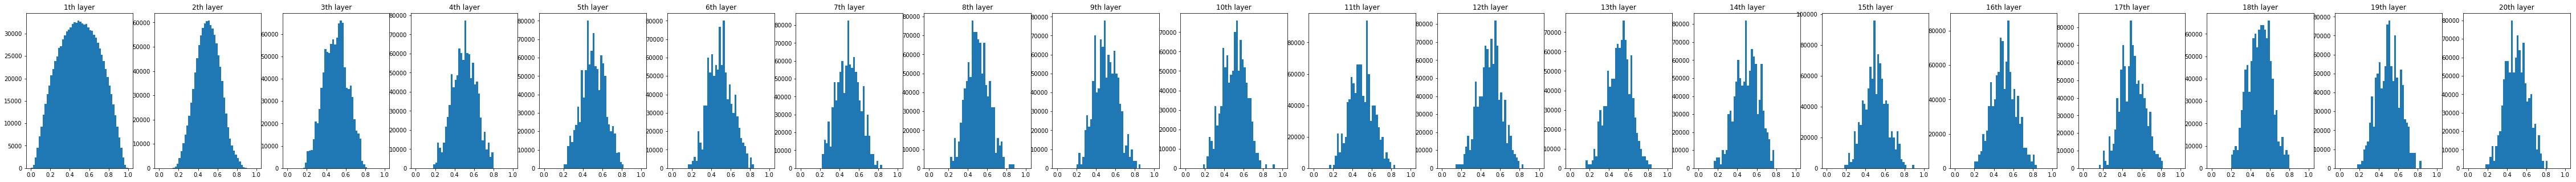

In [5]:
plt.figure(figsize=(80,5))
for idx, value in enumerate(history):
    plt.subplot(1, num_layer, idx+1)
    plt.title("{}th layer".format(idx+1))
    plt.hist(value.flatten(),50,range=(0,1))
plt.show()

순전파 과정 중에서도 층 별 출력 값의 분포가 크게 변화하지 않음을 볼 수 있습니다.<br>
Xavier 방식은 간단한 방법으로 출력값을 비슷하게 맞추어주는 효과가 있습니다.

### (3) relu에서의 Xavier 초기화

앞 강의에서 우리는 sigmoid 대신 활성화 함수로 relu를 이용하였습니다.<br>
Relu는 가장 대표적인 활성화 함수로, sigmoid와 달리 비대칭적인 형태를 가졌습니다.

In [6]:
def relu(x):
    return np.maximum(x,0)

num_data = 2000
unit_num = 512
num_layer = 20

X = np.random.randn(num_data, unit_num) 

history = []
a = X
for i in range(num_layer):
    W = np.random.normal(scale=np.sqrt(1/unit_num),
                         size=(unit_num,unit_num))
    z = np.dot(a,W)
    a = relu(z)
    history.append(a.copy())
    

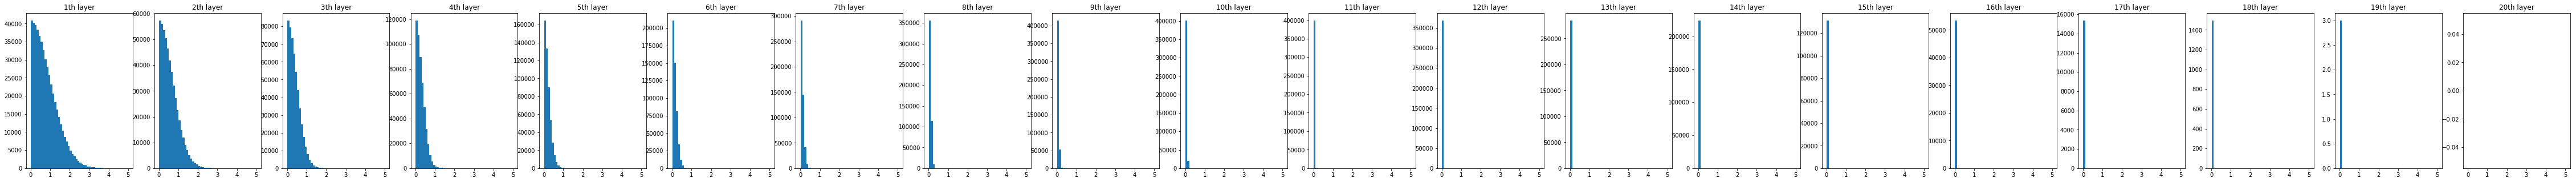

In [7]:
plt.figure(figsize=(80,5))
for idx, value in enumerate(history):
    plt.subplot(1, num_layer, idx+1)
    plt.title("{}th layer".format(idx+1))
    plt.hist(value.flatten(),50,range=(0.01,5))
plt.show()

활성화 함수로 relu 함수를 이용할 경우, Xavier로 하더라도 값의 분포가 계속 줄어듭니다.<br>
이는 relu의 형태에 기인한 문제입니다.

### (4) He 초기화

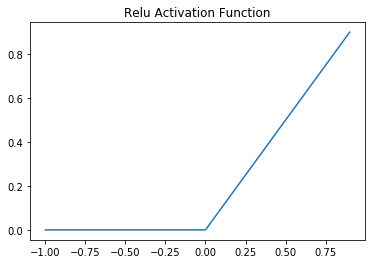

In [8]:
xs = np.arange(-1,1,0.1)
ys = relu(xs)

plt.title("Relu Activation Function")
plt.plot(xs,ys)
plt.show()

Relu는 강제적으로 입력 값이 0이하의 값들을 0으로 바꾸어버립니다. <br>
이렇기 때문에 값의 분산이 줄어드는 효과가 발생합니다.<br>
이를 보정하기 위해서 Xavier의 가중치 값의 분포에 2배를 곱하는 식으로 진행됩니다.<br>
$$
var(w) = \frac{2}{n}
$$
위의 수식을 허(He) 초기화라고 부릅니다.

In [9]:
def relu(x):
    return np.maximum(x,0)

num_data = 2000
unit_num = 512
num_layer = 20

X = np.random.randn(num_data, unit_num) 

history = []
a = X
for i in range(num_layer):
    W = np.random.normal(scale=np.sqrt(2/unit_num),
                         size=(unit_num,unit_num))
    z = np.dot(a,W)
    a = relu(z)
    history.append(a.copy())
    

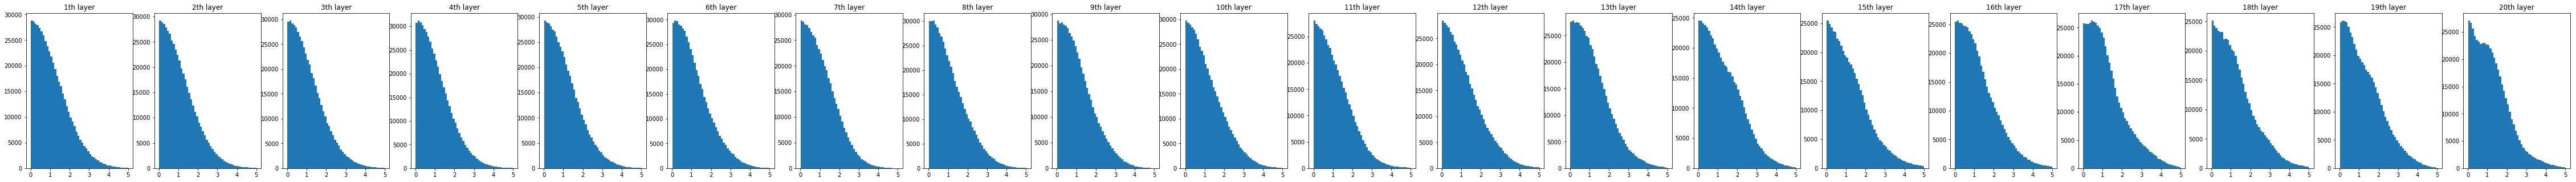

In [10]:
plt.figure(figsize=(80,5))
for idx, value in enumerate(history):
    plt.subplot(1, num_layer, idx+1)
    plt.title("{}th layer".format(idx+1))
    plt.hist(value.flatten(),50,range=(0.01,5))
plt.show()

Xavier와 달리, 값의 분포가 유지되는 것을 확인할 수 있습니다.

## 2. 활성화 함수와 초기화 매개변수
----

일반적으로 활성화 함수 종류에 따라 초기화는 아래의 매개변수들을 이용합니다.

| 활성화 함수 | 균등분포[-r,r] | 정규분포 |
| ---- | ---- | ---- |
| 로지스틱 | $r=\sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$ | $\sigma=\sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$ |
| tanh | $r=4*\sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$ | $\sigma=4\sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$ |
| RELU | $r=\sqrt{2}\sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$ | $\sigma=\sqrt{2}\sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$ |



### (1) 텐서플로우에서의 초기화 함수

텐서플로우에서도 위의 초기화 함수를 지원해줍니다.

In [11]:
tf.initializers.he_normal() # he init
tf.initializers.glorot_normal() # glorot은 xavier와 동일합니다.

위의 초기화 함수들은 아래와 같이 Tensorflow 내 다양한 High-API 메소드와<br>
연동하여 사용할 수 있습니다.

In [12]:
tf.reset_default_graph()

he_init = tf.initializers.he_normal()

# Data를 받아오는 placeholder
x = tf.placeholder(tf.float32, shape=(None, 784),
                   name='x')

a1 = tf.layers.Dense(100,activation='relu',
                     kernel_initializer=he_init,
                     name='hidden1')(x)

Instructions for updating:
Colocations handled automatically by placer.


#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/04

---